Current competition metric implies segmenation task. However one valid approach could incorporate object detection. In this direcrion and borrowing stuff from Kevin's excellent kernel [https://www.kaggle.com/kmader/baseline-u-net-model-part-1](http://), we attempt to extract bounding boxes information from binary rle-encoded masks.

In [1]:
! pip install opencv-python

    100% |████████████████████████████████| 25.4MB 2.1MB/s 
mxnet-model-server 0.4 requires mxnet-mkl>=1.2, which is not installed.
mxnet-model-server 0.4 has requirement onnx==1.1.1, but you'll have onnx 1.2.1 which is incompatible.
mxnet-cu90mkl 1.3.0.post0 has requirement requests<2.19.0,>=2.18.4, but you'll have requests 2.20.1 which is incompatible.
keras 2.2.2 has requirement keras-preprocessing==1.0.2, but you'll have keras-preprocessing 1.0.1 which is incompatible.
You are using pip version 10.0.1, however version 19.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
! pip install tqdm

    100% |████████████████████████████████| 51kB 30.8MB/s 
mxnet-model-server 0.4 requires mxnet-mkl>=1.2, which is not installed.
mxnet-model-server 0.4 has requirement onnx==1.1.1, but you'll have onnx 1.2.1 which is incompatible.
mxnet-cu90mkl 1.3.0.post0 has requirement requests<2.19.0,>=2.18.4, but you'll have requests 2.20.1 which is incompatible.
keras 2.2.2 has requirement keras-preprocessing==1.0.2, but you'll have keras-preprocessing 1.0.1 which is incompatible.
You are using pip version 10.0.1, however version 19.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import os
import cv2
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
from skimage.util.montage import montage2d as montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = '../input'
train_image_dir = 'trainimages'
test_image_dir = 'testimages'

from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list, all_masks=None):
    # Take the individual ship masks and create a single mask array for all ships
    if all_masks is None:
        all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

Let us read the masks:

In [14]:
masks = pd.read_csv("../../data/train_ship_segmentations_v2.csv")
print(masks.shape, 'masks found')
print(masks['ImageId'].value_counts().shape)
masks.head()

(231723, 2) masks found
(192556,)


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


and keep only those that contain ships. Keep in mind that image files can be repeated many times in the csv file. So a unique operator will give us the unique filenames that contain ships.

In [15]:
images_with_ship = masks.ImageId[masks.EncodedPixels.isnull()==False]
images_with_ship = np.unique(images_with_ship.values)
print('There are ' +str(len(images_with_ship)) + ' image files with masks')

There are 42556 image files with masks


Create a method to read image data frm the S3 bucket. OpenCV did not work.

In [87]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import boto3
import io

data_folder='/home/ec2-user/SageMaker/data'

def get_S3_image(image_name):
    s3 = boto3.resource('s3')
    bucket = s3.Bucket('vision-group-chicago')
    image_object = bucket.Object(image_name)

    image = mpimg.imread(io.BytesIO(image_object.get()['Body'].read()), 'jpg')
    return image

def get_Local_image(image_name):
    #print(data_folder + "/train/" + image_name)
    image = mpimg.imread("/home/ec2-user/SageMaker/data/train/" + image_name)
    return image


In order to extract the bounding box we:
1. Load mask as binary numpy array using Kevin's `masks_as_image`)

2. Label  connected regions of this mask using `skimage.measure.label`

3. Measure morphological properties of these connected regions and keep the bounding box (`skimage.measure.regionprops`). For each connected region a bounding box of the form  (min_row, min_col, max_row, max_col) is returned.  

(*Note: Ships masks touching each other would be considered as one. See Image 00021ddc3.jpg below. This may hurt detection performance but we can find ways to further split them !* )

Let us view some  examples:

000155de5.jpg
/home/ec2-user/SageMaker/data/train/000155de5.jpg
Image 000155de5.jpg
Found bbox (465, 344, 501, 448)


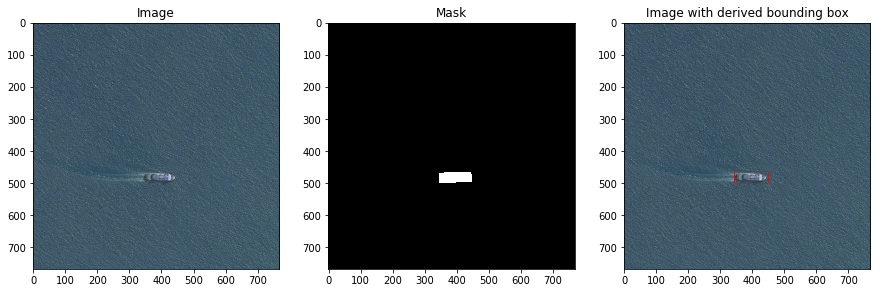

000194a2d.jpg
/home/ec2-user/SageMaker/data/train/000194a2d.jpg
Image 000194a2d.jpg
Found bbox (377, 67, 387, 85)
Found bbox (174, 258, 185, 306)
Found bbox (178, 331, 197, 370)
Found bbox (287, 469, 307, 492)


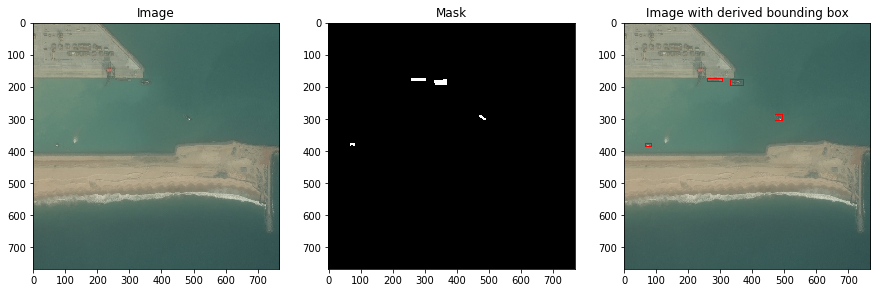

00021ddc3.jpg
/home/ec2-user/SageMaker/data/train/00021ddc3.jpg
Image 00021ddc3.jpg
Found bbox (705, 96, 720, 121)
Found bbox (732, 123, 768, 178)
Found bbox (629, 181, 638, 187)
Found bbox (661, 195, 665, 201)


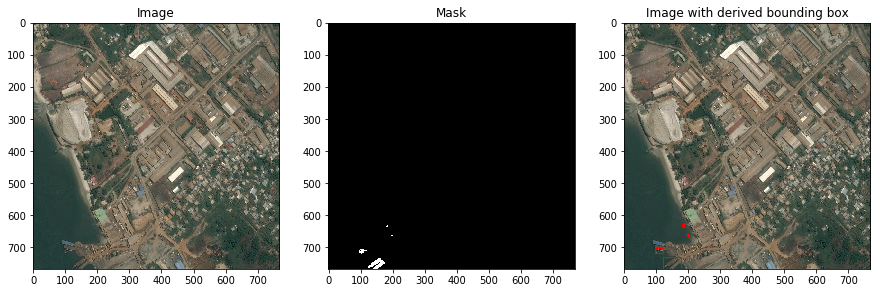

0002756f7.jpg
/home/ec2-user/SageMaker/data/train/0002756f7.jpg
Image 0002756f7.jpg
Found bbox (36, 324, 67, 351)


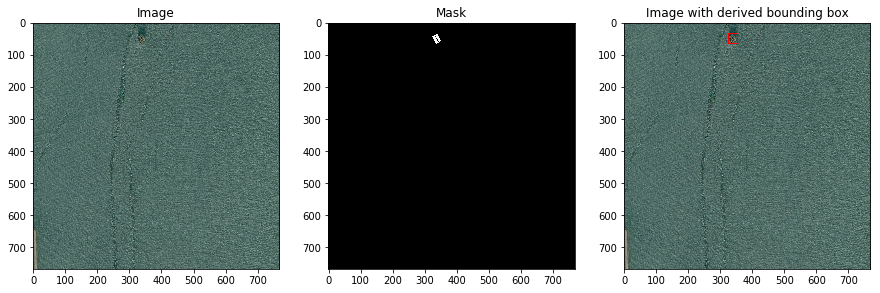

00031f145.jpg
/home/ec2-user/SageMaker/data/train/00031f145.jpg
Image 00031f145.jpg
Found bbox (124, 443, 153, 472)


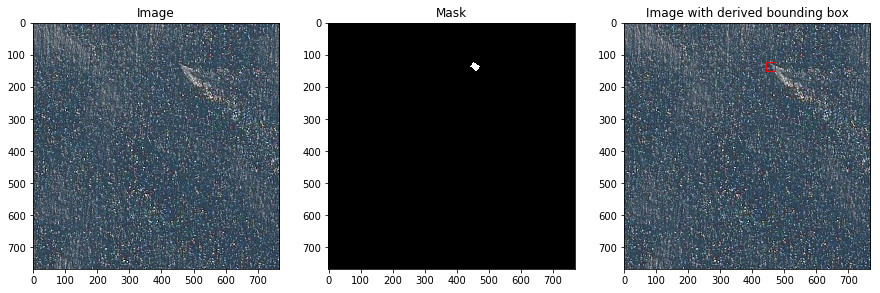

In [24]:
for i in range(5):
    image = images_with_ship[i]
    print(image)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
    img_0 = get_Local_image(image)
    rle_0 = masks.query('ImageId=="'+image+'"')['EncodedPixels']
    mask_0 = masks_as_image(rle_0)
    #
    # 
    lbl_0 = label(mask_0) 
    props = regionprops(lbl_0)
    img_1 = img_0.copy()
    print ('Image', image)
    for prop in props:
        print('Found bbox', prop.bbox)
        cv2.rectangle(img_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 2)


    ax1.imshow(img_0)
    ax1.set_title('Image')
    ax2.set_title('Mask')
    ax3.set_title('Image with derived bounding box')
    ax2.imshow(mask_0[...,0], cmap='gray')
    ax3.imshow(img_1)
    plt.show()

Here we calculate the bounding boxes for all `29070` images and save then into a dictionary. 

In [25]:
import gc 
bboxes_dict = {}
i = 0
count_ships = 0
for image in tqdm(images_with_ship):
    #img_0 = get_S3_image(train_image_dir+'/' + image)
    
    rle_0 = masks.query('ImageId=="'+image+'"')['EncodedPixels']
    mask_0 = masks_as_image(rle_0)
    

    #
    # 
    lbl_0 = label(mask_0) 
    props = regionprops(lbl_0)
    bboxes = []
    count_ships = count_ships + len(props)
    for prop in props:
        bboxes.append(prop.bbox)
        
        
    i = i + 1
    if i % 500 == 0:
        gc.collect()    

    bboxes_dict[image] = bboxes.copy()

100%|██████████| 42556/42556 [10:35<00:00, 66.97it/s]


Let us plot some bounding boxes right from the dictionary we just created. 

/home/ec2-user/SageMaker/data/train/000d42241.jpg


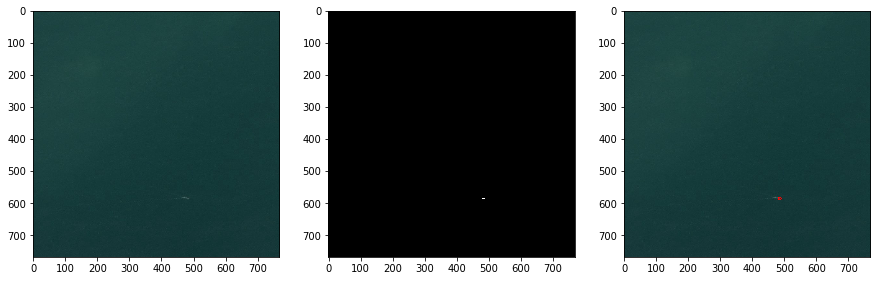

/home/ec2-user/SageMaker/data/train/000e6378b.jpg


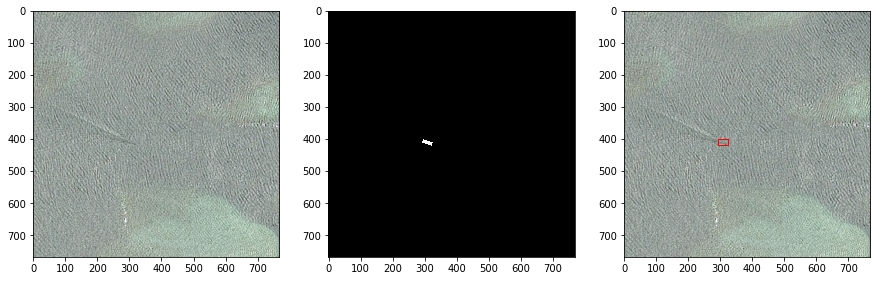

/home/ec2-user/SageMaker/data/train/000fd9827.jpg


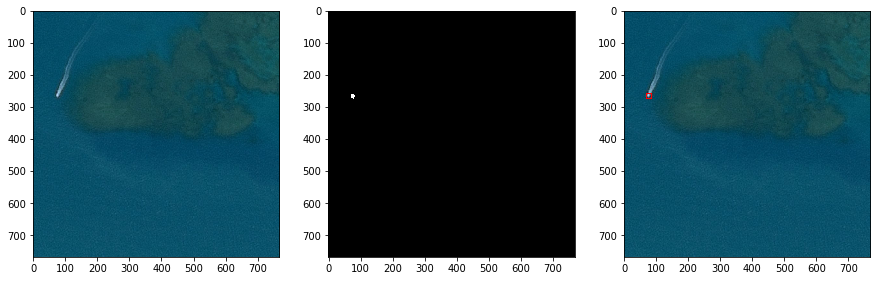

/home/ec2-user/SageMaker/data/train/00113a75c.jpg


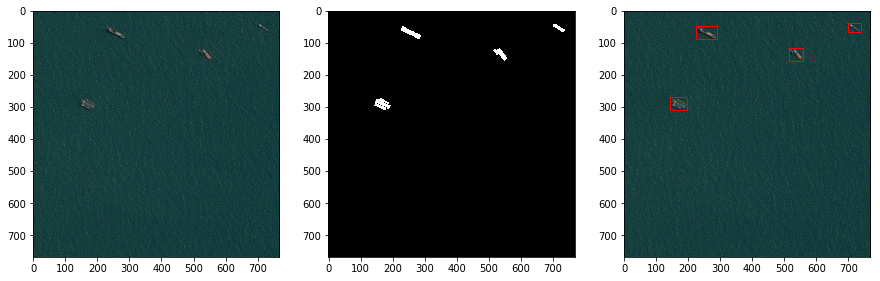

/home/ec2-user/SageMaker/data/train/001234638.jpg


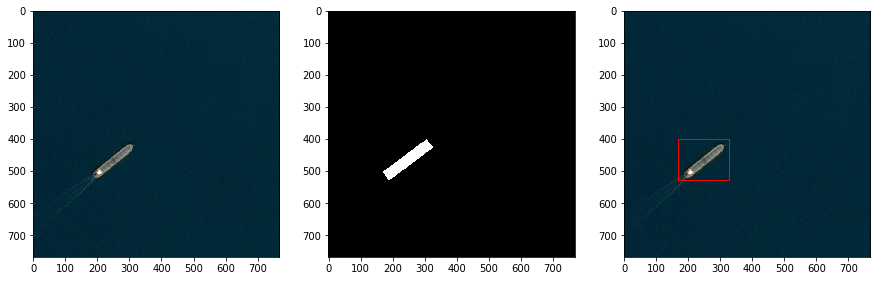

In [26]:
dict_images = list(bboxes_dict.keys())
for i in range(5):
    image = dict_images[10+i]
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
#     img_0 = get_S3_image(train_image_dir+'/' + image)
    img_0 = get_Local_image(image)
    rle_0 = masks.query('ImageId=="'+image+'"')['EncodedPixels']
    mask_0 = masks_as_image(rle_0)
    img_1 = img_0.copy()
    bboxs = bboxes_dict[image]
    for bbox in bboxs:
        cv2.rectangle(img_1, (bbox[1], bbox[0]), (bbox[3], bbox[2]), (255, 0, 0), 2)


    ax1.imshow(img_0)
    ax2.imshow(mask_0[...,0], cmap='gray')
    ax3.imshow(img_1)
    plt.show()

The final touch.. I export these bounding boxes for everyone to use in a Pandas dataframe form.

In [88]:
os.makedirs(data_folder + "/train_annotation/", exist_ok=True)
os.makedirs(data_folder + "/validation_annotation/", exist_ok=True)
os.makedirs(data_folder + "/train_new/", exist_ok=True)
os.makedirs(data_folder + "/validation_new/", exist_ok=True)

In [91]:
import shutil

def create_annotations(start, end, channel):
    for i in range(start, end):
        image = dict_images[i]
        #print(bboxes_dict[image][0][0])
        img_0 = get_Local_image(image)
        #print(img_0.shape)
        image_annotation = {}
        image_annotation['file'] = image
        image_annotation['image_size'] = [{"width":img_0.shape[0], "height":img_0.shape[1],"depth":img_0.shape[2]}]
        image_annotation['annotations'] = []
        for prop in bboxes_dict[image]:
            image_annotation['annotations'].append({"class_id":0,"left":prop[1],"top":prop[0],"width":prop[3] - prop[1],"height":prop[2] - prop[0]})
        image_annotation['categories'] = [{
             "class_id": 0,
             "name": "ship"
          }]
        #print (json.dumps(image_annotation))
        with open(os.path.join(data_folder + "/" + channel + "_annotation/", image.split('.')[0]+'.json'), 'w') as p:
            json.dump(image_annotation, p)
        shutil.copy(data_folder + "/train/" + image, data_folder + '/' + channel + '_new/' + image)


In [92]:
import json

dict_images = list(bboxes_dict.keys())
print(len(dict_images))
create_annotations(0, round(0.8 * len(dict_images)), 'train')
create_annotations(round(0.8 * len(dict_images)), len(dict_images), 'validation')

# bboxes_df = pd.DataFrame([bboxes_dict])
# bboxes_df = bboxes_df.transpose()
# print(bboxes_df.shape)
# bboxes_df.columns = ['image', 'bbox_list']
# bboxes_df.head()

42556


NotADirectoryError: [Errno 20] Not a directory: './train_new/000155de5.jpg'

In [93]:
bboxes_df.to_json('bbox_dictionary2.json')

In [ ]:
for index, row in bboxes_df.iterrows():
    print(row['c1'], row['c2'])